# Similar Charity Recommender - Built Using CharityNavigator Dataset

## Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import math
import random
import sys
from textwrap import wrap

pd.options.display.max_columns = 50

In [2]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
sns.set(color_codes=True)
# import folium
# import plotly.graph_objects as go
%matplotlib inline

In [4]:
import pprint
from collections import defaultdict
import gensim
from gensim import corpora, models, similarities
# NLTK Stop words
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
import pickle


## Functions

In [5]:
def freq_array(freq_list):
    '''
    Functions:
    ---------
    1. Create frequency array
    
    Parameters:
    ----------
    1. freq_list : list of values and frequencies
    
    Returns:
    -------
    1. frequency array
    '''
    freq = []
    for i in freq_list:
        freq.append(i)
    return freq

In [6]:
def wrap_axis_labels(labels_list,wrap_length=13):
    '''
    Functions:
    ---------
    1. Wrap axis labels at a specified character length
    
    Parameters:
    ----------
    1. labels_list : List of labels
    2. wrap_length : Max character length before wrapping
    
    Returns:
    -------
    1. wrapped labels list
    '''
    labels_list = [ '\n'.join(wrap(l, wrap_length)) for l in labels_list]
    return labels_list

In [7]:
def set_labels(freq, ax,horz_shift=.2,vert_shift=1000,w="bold",fsize=10,c="b"):
    '''
    Functions:
    ---------
    1. Set frequency labels on bar plot
    
    Parameters:
    ----------
    1. freq : List of frequencies to plot for each bar
    2. ax : Axis to Plot Frequency Labels on
    3. horz_shift : Shift labels left/right
    4. vert_shift : Shift labels up/down
    5. w : "weight" -> Bold by default
    6. fsize : fontsize
    7. c : label color
    
    Returns:
    -------
    N/A
    '''
    for i, v in enumerate(freq):
        ax.text(i-horz_shift,v+vert_shift, str(round(v,2)), weight = w,fontsize=fsize,color = c)
    pass

In [8]:
def set_labels_horizontal(freq, ax,horz_shift=.2,vert_shift=1000,w="bold",fsize=10,c="b"):
    '''
    Functions:
    ---------
    1. Set Frequency Labels on Bar Plot - Horizontally
    
    Parameters:
    ----------
    1. freq : List of frequencies to plot for each bar
    2. ax : Axis to Plot Frequency Labels on
    3. horz_shift : Shift labels left/right
    4. vert_shift : Shift labels up/down
    5. w : "weight" -> Bold by default
    6. fsize : fontsize
    7. c : label color
    
    Returns:
    -------
    N/A
    '''
    for i, v in enumerate(freq):
        ax.text(v-horz_shift,i+vert_shift, str(round(v,2)), weight = w,fontsize=fsize,color = c)
    pass

In [251]:
def process_corpus(text_corpus,min_docs=3,max_percent=0.1):
    '''
    Functions:
    ---------
    1. Process corpus by: 
        lowercasing words, removing 1-letter words, removing punctuation and numbers, removing stopwords, 
        removing words in less than [min-words] documents and more than [max_percent] of documents
    
    Parameters:
    ----------
    1. text_corpus : Unprocessed Text Corpus
    2. min_words: Minimum word cutoff to remove words from dictionary
    3. max_percent: Maximimum percent cutoff to remove words from dictionary
    
    Returns:
    -------
    1. texts : Processed Text Corpus
    2. dictionary : Trimmed Dictionary
    ''' 
    # Create Stop Words List
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    
    text_corpus2 = []
    lemma = WordNetLemmatizer()

    # Iterate through each document in corpus -> lowercase each document
    for document in text_corpus:
        document = document.lower()
        word_list = []
        
        # Iterate through each word in document -> remove 1-letter words
        for word in document.split():
            ch_list = ''
            
            # Iterate through each character in word -> remove punctuation and numbers
            for ch in word:
                if ch not in set(string.punctuation) and not ch.isdigit() :
                    ch_list += ch
            if len(ch_list) > 1:
                word_list.append(ch_list)

        document = ' '.join(word_list)
        document = ' '.join([lemma.lemmatize(word) for word in document.split()])

        text_corpus2.append(document)

    texts = [[word for word in document.lower().split() if word not in stop_words] for document in text_corpus2]
    
    dictionary = corpora.Dictionary(texts)
    
    # Remove words that appear less than [min_words] times and that are in more than in [max_percent] documents
    dictionary.filter_extremes(no_below=min_docs, no_above=max_percent)
    
    return texts, dictionary

In [252]:
#     # Count word frequencies
#     frequency = defaultdict(int)
#     for text in texts:
#         for token in text:
#             frequency[token] += 1
        
          
#     # Only keep words that appear more than [min_words] times, 
#     # are in less than [] of documents, and are alphabetical strings
#     max_percent_calc = (int(len(text_corpus)*(1-(max_percent))))
    
# #     print('max_percent_calc',max_percent_calc)
    
#     processed_corpus = []
#     for text in texts:
#         token_list = []
#         for token in text:
#             if frequency[token] > min_words and frequency[token] < max_percent_calc and str.isalpha(token):
#                 token_list.append(token)
# #             else:
# #                 print('frequency[token]',frequency[token])
#         processed_corpus.append(token_list)

In [253]:
def create_index_from_corpus(processed_corpus, dictionary):
    '''
    Functions:
    ---------
    1. Trains model on processed corpus
    2. Also creates index, dictionary, and tf-idf model from processed corpus
    
    Parameters:
    ----------
    1. processed_corpus : Processed Text Corpus
    
    Returns:
    -------
    1. index: cosine similarity of vectors of documents
    2. tfidf: trained tfidf model
    ''' 
    features = (len(dictionary))
    
    # Convert documents into Bag of Words (BoW) format
    bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
    
    # train the model
    tfidf = models.TfidfModel(bow_corpus)
    
    # Get cosine similarity of vectors of documents
    index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=features)
    
    return index, tfidf

In [254]:
def find_similar_charities_category_score(train_df,test_df,column,min_docs=3,max_percent=0.1):
    '''
    Functions:
    ---------
    1. Train model on "corpus" column - composed of charity category, description, motto and state
    2. Score model on category score given parameters
    
    Parameters:
    ----------
    1. train_df : DataFrame to Train LDA Model
    2. test_df : DataFrame to Test and Score Model
    3. column : DataFrame column name to test model on
    4. min_words: Minimum word cutoff to remove words from dictionary
    5. max_percent: Maximimum percent cutoff to remove words from dictionary
    
    Returns:
    -------
    1. top_3_sim : DataFrame of Top 3 Most Similar Charities
    2. Average category score
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    
#     print("1. Processing Training Corpus")
    
    corpus = np.array(train_df[column])
    
    processed_corpus, dictionary = process_corpus(corpus,min_docs=min_docs,max_percent=max_percent)
    
#     print("2. Creating Model from Training Corpus")
    index, tfidf = create_index_from_corpus(processed_corpus, dictionary)
    
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    
    lemma = WordNetLemmatizer()
    
#     print("3. Starting Test Corpus Category Analysis\n")
    for ind, document in enumerate(test_df[column]):
        total +=1 
#         if total % 500 == 0:
#             print("Analyzed",total,"documents...")
        
        document = document.lower()
        word_list = []

        # Iterate through each word in document -> remove 1-letter words
        for word in document.split():
            ch_list = ''

            # Iterate through each character in word -> remove punctuation and numbers
            for ch in word:
                if ch not in set(string.punctuation) and not ch.isdigit() :
                    ch_list += ch
            if len(ch_list) > 1:
                word_list.append(ch_list)

        document = ' '.join(word_list)
        document = ' '.join([lemma.lemmatize(word) for word in document.split()])

        texts = [word for word in document.lower().split() if word not in stop_words]

        document = ' '.join(texts)
        
        query_bow = dictionary.doc2bow(document.split())
        
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
            
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        
        for doc, score in top_3_sim.items():
            if train_df['category'].iloc[doc] == test_df['category'].iloc[ind]:
                category_counter[category_count] += 1
            category_count += 1
        
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
#     print ("\nFirst Recommendation Score:", first_rec_score,"%")
#     print ("Second Recommendation Score:", second_rec_score,"%")   
#     print ("Third Recommendation Score:", third_rec_score,"%\n")
    
#     print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    return top_3_sim, round((first_rec_score+second_rec_score+third_rec_score)/3,2)
    

In [255]:
def find_similar_charities_similar_score(train_df,test_df,column,min_docs=3,max_percent=0.1):
    '''
    Functions:
    --------
    1. Train model on "corpus" column - composed of charity category, description, motto and state
    2. Score model on similarity score given parameters
    
    Parameters:
    ----------
    1. train_df : DataFrame to Train LDA Model
    2. test_df : DataFrame to Test and Score Model
    3. column : DataFrame column name to test model on
    4. min_words: Minimum word cutoff to remove words from dictionary
    5. max_percent: Maximimum percent cutoff to remove words from dictionary
    
    Returns:
    -------
    1. top_3_sim : DataFrame of Top 3 Most Similar Charities
    2. Average similarity score
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    
#     print("1. Processing Training Corpus")
    
    corpus = np.array(train_df[column])

    processed_corpus, dictionary = process_corpus(corpus,min_docs=min_docs,max_percent=max_percent)
    
#     print("2. Creating Model from Training Corpus")
    index, tfidf = create_index_from_corpus(processed_corpus, dictionary)
    
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    
    lemma = WordNetLemmatizer()
    
#     print("3. Starting Test Corpus Similarity Analysis\n")
    for ind, document in enumerate(test_df[column]):
        total +=1 
#         if total % 500 == 0:
#             print("Analyzed",total,"documents...")
        
        document = document.lower()
        word_list = []

        # Iterate through each word in document -> remove 1-letter words
        for word in document.split():
            ch_list = ''

            # Iterate through each character in word -> remove punctuation and numbers
            for ch in word:
                if ch not in set(string.punctuation) and not ch.isdigit() :
                    ch_list += ch
            if len(ch_list) > 1:
                word_list.append(ch_list)

        document = ' '.join(word_list)
        document = ' '.join([lemma.lemmatize(word) for word in document.split()])

        texts = [word for word in document.lower().split() if word not in stop_words]

        document = ' '.join(texts)
        
        query_bow = dictionary.doc2bow(document.split())
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
            
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        
        for doc, score in top_3_sim.items():     
            category_counter[category_count] += score
            category_count +=1
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    avg_score = round((first_rec_score+second_rec_score+third_rec_score)/3,2)
    
#     print ("\nFirst Recommendation Score:", first_rec_score,"%")
#     print ("Second Recommendation Score:", second_rec_score,"%")   
#     print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    
    
#     print ("AVG Recommendation Score:", avg_score,"%")
    
    return top_3_sim, avg_score
    

In [568]:
def find_cat_and_sim_charities_score(train_df,test_df,column,min_docs=3,max_percent=0.1):
    '''
    Functions:
    --------
    1. Train model on "corpus" column - composed of charity category, description, motto and state
    2. Score model on similarity score given parameters
    
    Parameters:
    ----------
    1. train_df : DataFrame to Train LDA Model
    2. test_df : DataFrame to Test and Score Model
    3. column : DataFrame column name to test model on
    4. min_words: Minimum word cutoff to remove words from dictionary
    5. max_percent: Maximimum percent cutoff to remove words from dictionary
    
    Returns:
    -------
    1. top_3_sim : DataFrame of Top 3 Most Similar Charities
    2. Average similarity score
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    similarity_counter = {1:0,2:0,3:0}
    
    # print("1. Processing Training Corpus")
    
    corpus = np.array(train_df[column])

    processed_corpus, dictionary = process_corpus(corpus,min_docs=min_docs,max_percent=max_percent)
    
    # print("2. Creating Model from Training Corpus")
    index, tfidf = create_index_from_corpus(processed_corpus, dictionary)
    
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    
    lemma = WordNetLemmatizer()
    
    # print("3. Starting Test Corpus Similarity Analysis\n")
    for ind, document in enumerate(test_df[column]):
        total +=1 
        # if total % 500 == 0:
        #     print("Analyzed",total,"documents...")
        
        document = document.lower()
        word_list = []

        # Iterate through each word in document -> remove 1-letter words
        for word in document.split():
            ch_list = ''

            # Iterate through each character in word -> remove punctuation and numbers
            for ch in word:
                if ch not in set(string.punctuation) and not ch.isdigit() :
                    ch_list += ch
            if len(ch_list) > 1:
                word_list.append(ch_list)

        document = ' '.join(word_list)
        document = ' '.join([lemma.lemmatize(word) for word in document.split()])

        texts = [word for word in document.lower().split() if word not in stop_words]

        document = ' '.join(texts)
        
        query_bow = dictionary.doc2bow(document.split())
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
            
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        similarity_count = 1
        
        for doc, score in top_3_sim.items():     
            # Category Scores
            if train_df['category'].iloc[doc] == test_df['category'].iloc[ind]:
                category_counter[category_count] += 1
            category_count += 1
            
            # Similarity Scores
            similarity_counter[similarity_count] += score
            similarity_count +=1
            
    # Category    
    first_rec_score_cat = round((category_counter[1] / total)*100,2)
    second_rec_score_cat = round((category_counter[2] / total)*100,2)
    third_rec_score_cat = round((category_counter[3] / total)*100,2)
    avg_score_cat = round((first_rec_score_cat+second_rec_score_cat+third_rec_score_cat)/3,2)
    
    # Similarity        
    first_rec_score_sim = round((similarity_counter[1] / total)*100,2)
    second_rec_score_sim = round((similarity_counter[2] / total)*100,2)
    third_rec_score_sim = round((similarity_counter[3] / total)*100,2)
    avg_score_sim = round((first_rec_score_sim+second_rec_score_sim+third_rec_score_sim)/3,2)
    
    return top_3_sim, avg_score_cat, avg_score_sim
    

In [256]:
def find_similar_charities_from_search(train_df,search_text):
    '''
    Functions:
    ---------
    1. Train Model on "corpus" column - composed of charity category, description, motto and state
    
    Parameters:
    ----------
    1. train_df : DataFrame to Train LDA Model
    2. test_df : DataFrame to Test and Score Model
    
    Returns:
    -------
    1. top_3_sim : DataFrame of Top 3 Most Similar Charities
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    print("1. Processing Training Corpus")
    
    corpus = np.array(train_df['corpus'])

    processed_corpus, dictionary = process_corpus(corpus)
    
    print("2. Creating Model from Training Corpus")
    index, tfidf = create_index_from_corpus(processed_corpus, dictionary)
    
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    
    lemma = WordNetLemmatizer()
    
    print("3. Starting Test Corpus Similarity Analysis\n")
    
    total +=1 
    if total % 500 == 0:
        print("Analyzed",total,"documents...")

    document = search_text.lower()
    word_list = []

    # Iterate through each word in document -> remove 1-letter words
    for word in document.split():
        ch_list = ''

        # Iterate through each character in word -> remove punctuation and numbers
        for ch in word:
            if ch not in set(string.punctuation) and not ch.isdigit() :
                ch_list += ch
        if len(ch_list) > 1:
            word_list.append(ch_list)

    document = ' '.join(word_list)
    document = ' '.join([lemma.lemmatize(word) for word in document.split()])

    texts = [word for word in document.lower().split() if word not in stop_words]

    document = ' '.join(texts)
        
    query_bow = dictionary.doc2bow(document.split())
    sims = index[tfidf[query_bow]]
    
    top_3_sim = dict()
    count = 3

    for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:

        if count > 0:
            top_3_sim[document_number] = score
        count -= 1

    category_count = 1

    for doc, score in top_3_sim.items():     
        category_counter[category_count] += score
        category_count +=1
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    avg_score = round((first_rec_score+second_rec_score+third_rec_score)/3,2)

    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    return top_3_sim, avg_score
    

In [257]:
def create_sim_word_dict(text1, text2, dictionary):
    '''
    Functions:
    ---------
    1. Create dictionary of the counts of mutual words between two texts that are in trained model's dictionary
    
    Parameters:
    ----------
    1. text1 : first text to compare
    2. text2 : second text to compare
    3. dictionary : dictionary of words used in training tfidf model
    
    Returns:
    -------
    1. similar_words : dictionary of the counts of mutual words between the two texts
    '''
    text1_array = text1.split()
    text2_array = text2.split()

    dict_list = []
    for i in range(len(dictionary)):
        dict_list.append(dictionary[i])
    dict_list = np.array(dict_list)

    similar_words = dict()

    for word in text1_array:
        if word in text2_array and word in dict_list:
            if word not in similar_words:
                similar_words[word] = 1
            else:
                similar_words[word] +=1

    return similar_words

In [258]:
def get_recs_from_pickled_model(document):
    '''
    Functions:
    ---------
    1. Get recommendations from pickled model
    
    Parameters:
    ----------
    1. document : document text to compare to pickled model
    
    Returns:
    -------
    1. top_3_sim : top 3 charity recommendations based on similarity to document
    '''
    # load the model from disk
    loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
    # load the index from disk
    loaded_index = pickle.load(open('finalized_index.sav', 'rb'))
    # load the dictionary from disk
    loaded_dict = pickle.load(open('finalized_dict.sav', 'rb'))
    
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    
    lemma = WordNetLemmatizer()
    
    print("3. Starting Test Corpus Similarity Analysis\n")
    
    total +=1 
    if total % 500 == 0:
        print("Analyzed",total,"documents...")

    document = search_text.lower()
    word_list = []

    # Iterate through each word in document -> remove 1-letter words
    for word in document.split():
        ch_list = ''

        # Iterate through each character in word -> remove punctuation and numbers
        for ch in word:
            if ch not in set(string.punctuation) and not ch.isdigit() :
                ch_list += ch
        if len(ch_list) > 1:
            word_list.append(ch_list)

    document = ' '.join(word_list)
    document = ' '.join([lemma.lemmatize(word) for word in document.split()])

    texts = [word for word in document.lower().split() if word not in stop_words]

    document = ' '.join(texts)
    
    query_bow = loaded_dict.doc2bow(document.split())

    sims = loaded_index[loaded_model[query_bow]]

    top_3_sim = dict()
    
    for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
        top_3_sim[document_number] = score
        
    return top_3_sim

## Loading Charity Navigator Data

In [16]:
charity_navigator_df = pd.read_csv('../data/charities_rated_corpus.csv')
charity_navigator_df.drop(columns=['Unnamed: 0'],inplace=True)
charity_navigator_df.head()

,name,ein,category,description,motto,score,state,corpus
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR,Environment Working with Oregonians to enhance...
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD,"Arts, Culture, Humanities Serving the metropol..."
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE,Religion VSS Catholic Communications is dedica...
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT,"Arts, Culture, Humanities The mission of the U..."
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA,Human Services Funded solely by the footwear i...


# Exploratory Data Analysis

In [17]:
charity_navigator_df.head()

,name,ein,category,description,motto,score,state,corpus
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR,Environment Working with Oregonians to enhance...
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD,"Arts, Culture, Humanities Serving the metropol..."
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE,Religion VSS Catholic Communications is dedica...
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT,"Arts, Culture, Humanities The mission of the U..."
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA,Human Services Funded solely by the footwear i...


## Category

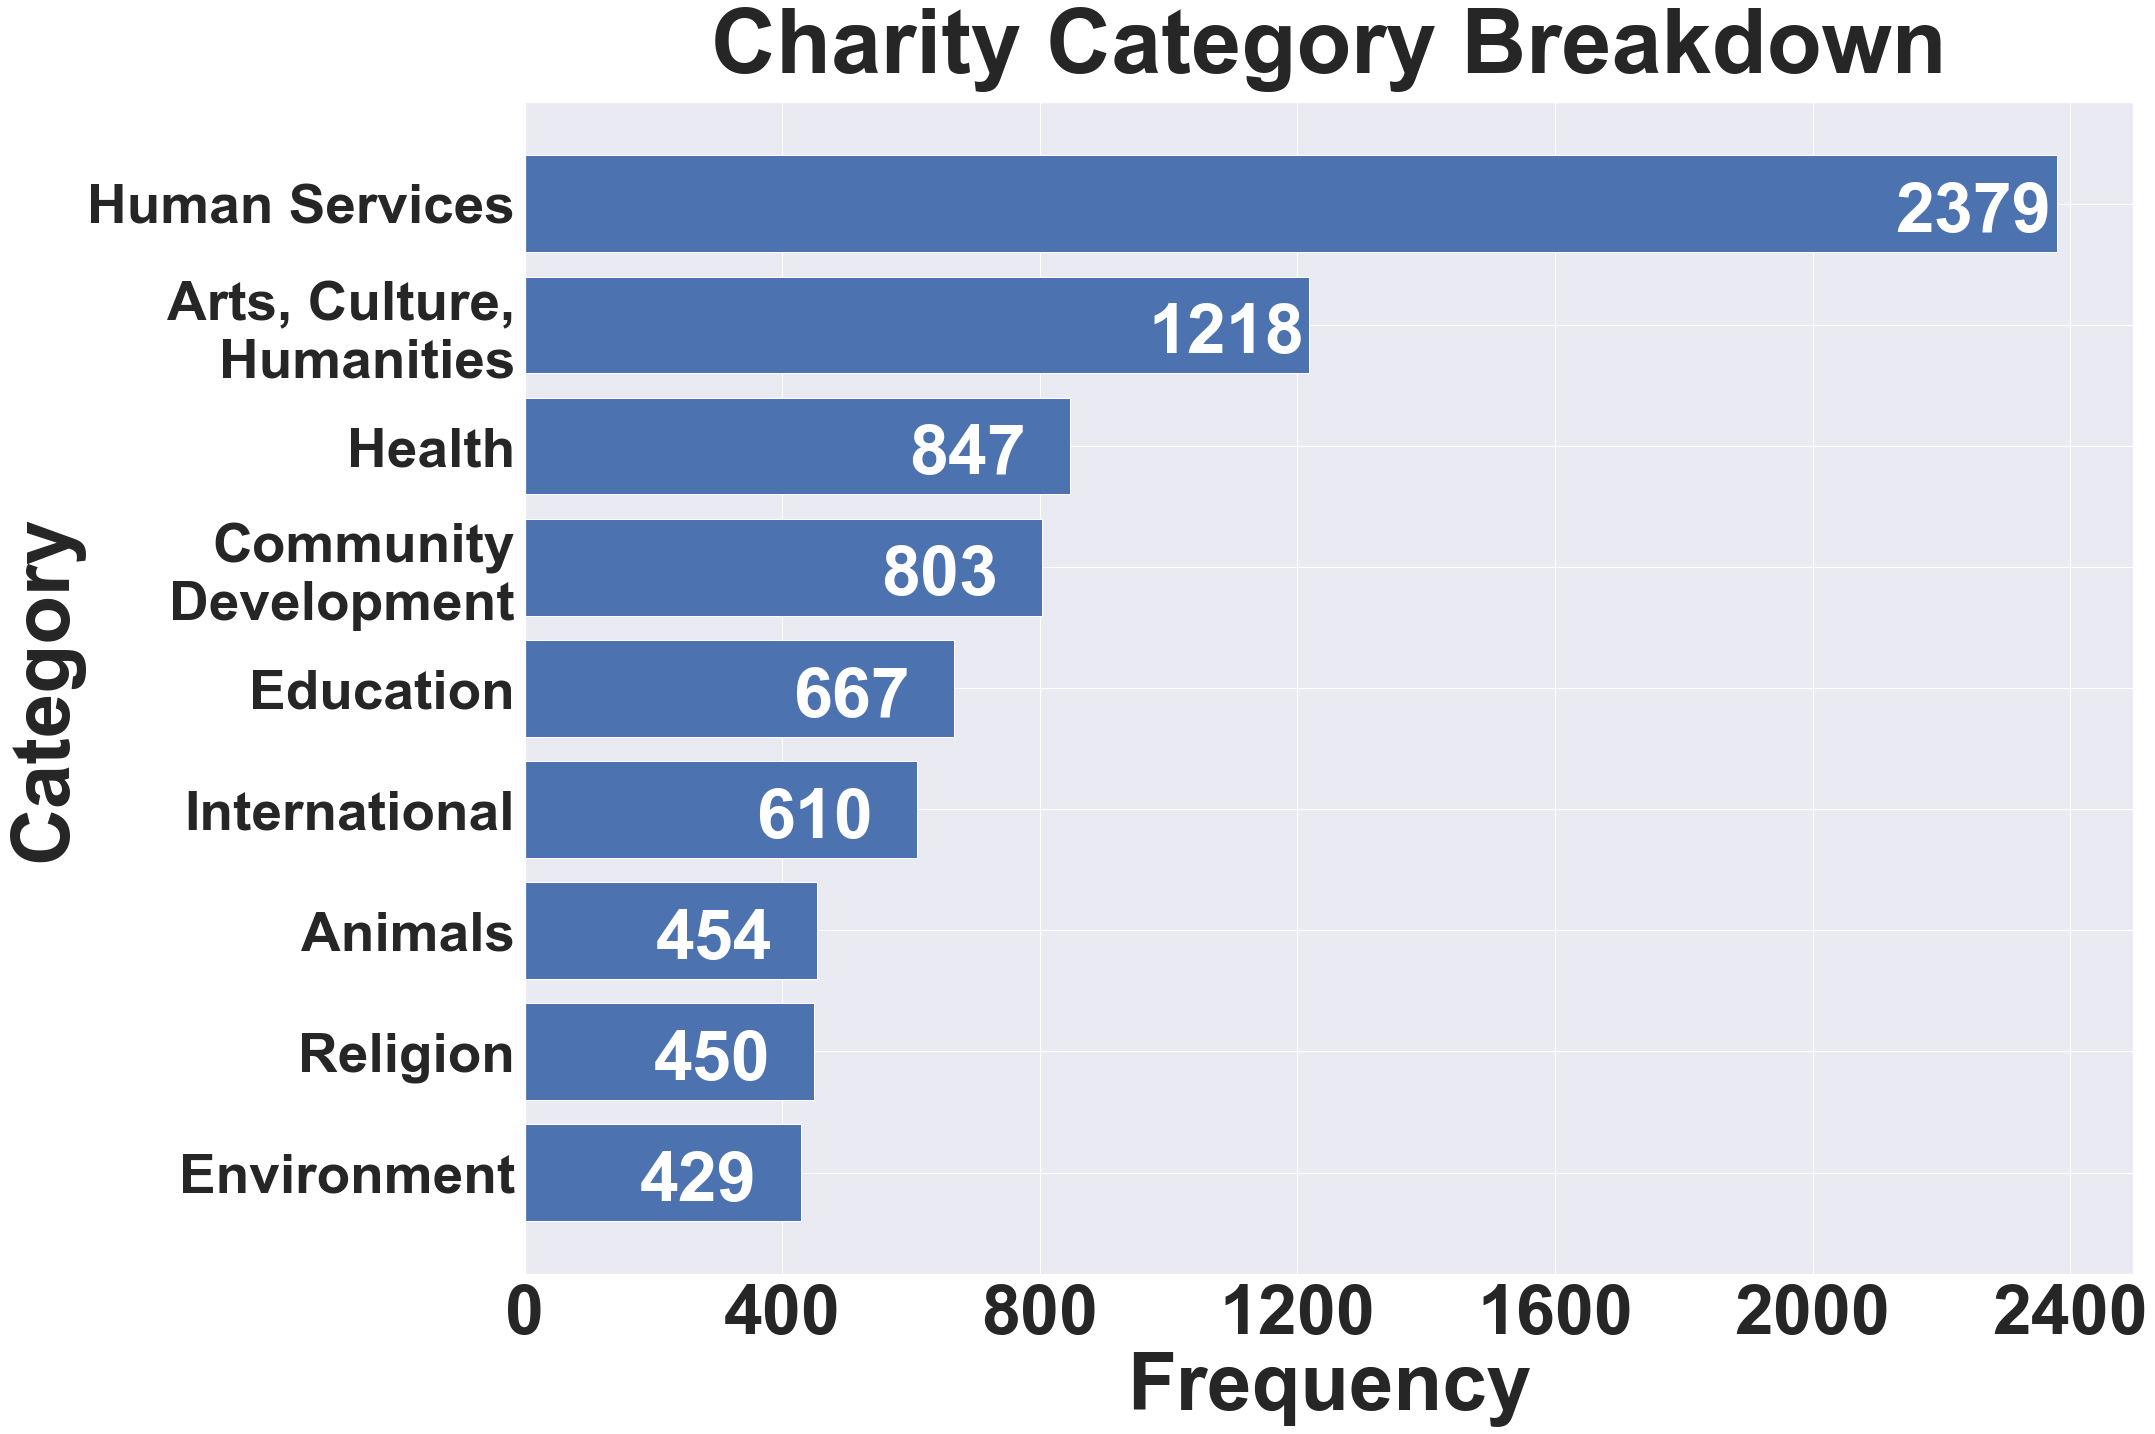

In [19]:
## Category Bar Chart
category_count = charity_navigator_df.groupby('category').size().sort_values(ascending=False)[:9]
categories = list(category_count.index.values)
freq = freq_array(category_count)

fig,ax = plt.subplots(figsize = (30,20))
ax.barh(categories,freq, color = "b");

# Title
ax.set_title("Charity Category Breakdown", weight = "bold", fontsize = 90, y=1.02);

# # X-axis
x_tick_nums = np.arange(0,np.max(category_count)+400,400)
ax.set_xticks(x_tick_nums)
ax.set_xticklabels(labels=x_tick_nums,weight='bold',fontsize=70)
ax.set_xlabel("Frequency", fontsize=80, weight = "bold");

# # Y-axis
categories_wrapped = wrap_axis_labels(categories, wrap_length=15)
ax.set_yticklabels(labels=categories_wrapped,weight='bold',fontsize=55)
ax.set_ylabel("Category", fontsize=80, weight = "bold");

set_labels_horizontal(category_count,ax,250,.23,c="white",fsize=70);

ax.invert_yaxis()  # labels read top-to-bottom

plt.tight_layout()

# plt.savefig('../IMG/CN_Categories.png')

## Charity Navigator Scores

In [20]:
charity_navigator_df['score'].median()

88.31

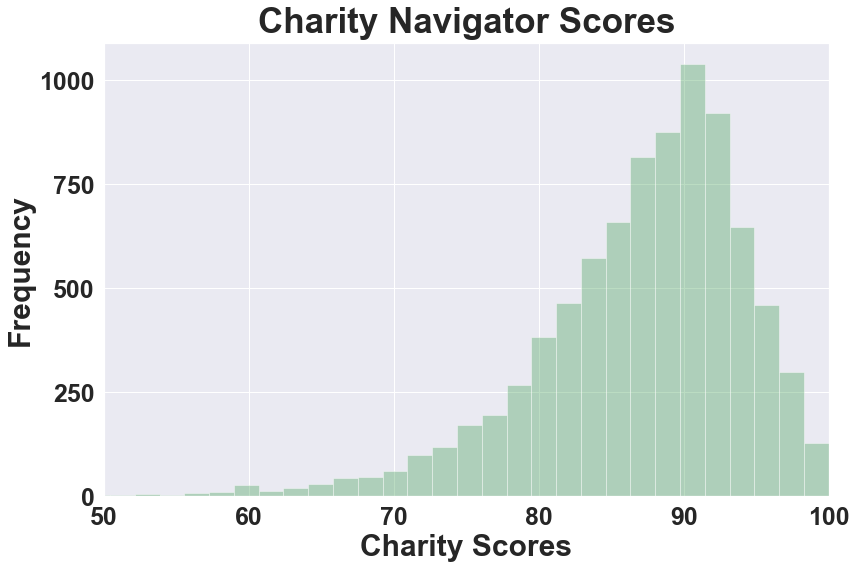

In [21]:
# Histogram of Charity Navigator Scores
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.distplot(charity_navigator_df['score'],color = 'g',kde=False,hist=True,norm_hist=False)

# Title
ax.set_title(label="Charity Navigator Scores",weight='bold',fontsize=35, y=1.01)

# X-axis
x_tick_nums = np.arange(0,101,10)
ax.set_xticks(x_tick_nums)
ax.set_xticklabels(labels=x_tick_nums,weight='bold',fontsize=25)
ax.set_xlabel(xlabel="Charity Scores",weight='bold',fontsize=30)
ax.set_xlim([50, 100])

# Y-axis
y_tick_nums = np.arange(0,1101,250)
ax.set_yticks(y_tick_nums)
ax.set_yticklabels(labels=y_tick_nums,weight='bold',fontsize=25)
ax.set_ylabel(ylabel="Frequency",weight='bold',fontsize=30)

plt.tight_layout()

# plt.savefig('../IMG/CharityNavScores.png')

## State

In [742]:
# import folium
import plotly.graph_objects as go

state_count = charity_navigator_df.groupby('state').size().sort_values(ascending=False)
ColorScale = 'Blues'

## Add Choropleth Map
fig = go.Figure(
    data=go.Choropleth(
        locations = state_count.index,
        z=state_count,
        zmax=1001,
        zmin=0,
        locationmode='USA-states',
        colorscale='Blues',
        autocolorscale=False,
        marker_line_color='black', # line markers between states
        colorbar_title="Charity Counts"
))

fig.update_layout(
    title_text='Charity Counts by State',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

## Character Lengths

In [23]:
charity_navigator_df.head()

,name,ein,category,description,motto,score,state,corpus
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR,Environment Working with Oregonians to enhance...
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD,"Arts, Culture, Humanities Serving the metropol..."
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE,Religion VSS Catholic Communications is dedica...
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT,"Arts, Culture, Humanities The mission of the U..."
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA,Human Services Funded solely by the footwear i...


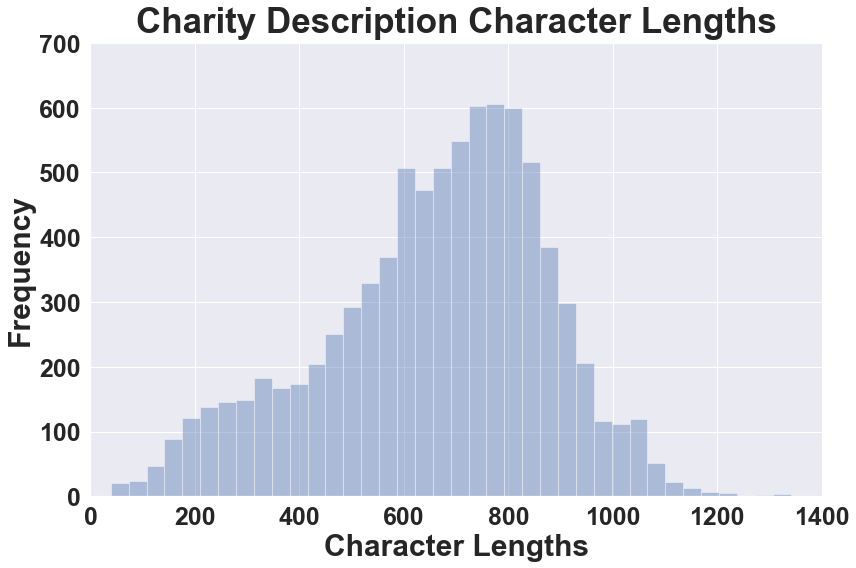

In [24]:
# Histogram of Charity Document Charity Lengths
fig, ax = plt.subplots(figsize=(12,8))

char_corp_lengths = []
for i in charity_navigator_df['corpus']:
    char_corp_lengths.append(len(i))
char_corp_lengths = np.array(char_corp_lengths)
np.median(char_corp_lengths)

ax = sns.distplot(char_corp_lengths,color = 'b',kde=False,hist=True,norm_hist=False)

# Title
ax.set_title(label="Charity Description Character Lengths",weight='bold',fontsize=35, y=1.01)

# X-axis
x_tick_nums = np.arange(0,1601,200)
ax.set_xticks(x_tick_nums)
ax.set_xticklabels(labels=x_tick_nums,weight='bold',fontsize=25)
ax.set_xlabel(xlabel="Character Lengths",weight='bold',fontsize=30)
ax.set_xlim([0,1400])

# Y-axis
y_tick_nums = np.arange(0,701,100)
ax.set_yticks(y_tick_nums)
ax.set_yticklabels(labels=y_tick_nums,weight='bold',fontsize=25)
ax.set_ylabel(ylabel="Frequency",weight='bold',fontsize=30)

plt.tight_layout()

# plt.savefig('../IMG/CharityDescCharacterLengths.png')

# Creating the Similarity Recommender Model

## Functions

In [689]:
def run_cat_and_sim(min_docs_list,max_docs_percentage_list):
    '''
    Functions:
    ---------
    1. Run similarity analysis given minimum words and maximum percantage parameters
    
    Parameters:
    ----------
    1. min_words: Minimum word cutoff to remove words from dictionary
    2. max_percent: Maximimum percent cutoff to remove words from dictionary
    
    Returns:
    -------
    1. scores_list : list of scores from each iteration of similarity analysis
    2. best_score : best overall score from analysis
    3. best_score_min_words : minimum word parameter that led to best score
    4. best_score_percentage : maximum percentage parameter that led to best score
    '''
    # Data Structure Initialization
    cat_scores_list, sim_scores_list = [], []
    
    # Corpus - Baseline
    for max_percent in max_docs_percentage_list:
        for min_docs in min_docs_list:
            print("Creating Model With Tokens in at least {} Documents and at most {}% of Documents".format(min_docs,(max_percent)*100))
            recs, cat_score, sim_score = find_cat_and_sim_charities_score(charity_navigator_df,charity_navigator_df,"corpus",min_docs=min_docs,max_percent=max_percent)
            
            cat_scores_list.append(cat_score)
            sim_scores_list.append(sim_score)
            
    return cat_scores_list, sim_scores_list

# Scoring & Evaluating the Model

## Category & Similarity Analysis

In [690]:
%%time
min_docs_list = np.round(np.linspace(0,10,11),2)
max_docs_percentage_list = np.round(np.linspace(0.05,.30,6),3)

categorical_scores_list, sim_scores_list = run_cat_and_sim(min_docs_list,max_docs_percentage_list)

Creating Model With Tokens in at least 0.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 1.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 2.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 3.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 4.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 5.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 6.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 7.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 8.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 9.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 10.0 Documents and at most 5.0% of Documents
Creating Model With Tokens in at least 0.0 Documents and at most 10.0% of Documents
Cr

## Graphical Model Analysis

In [646]:
import matplotlib.ticker as mtick

def make_graph_2d(max_docs_percentage_list,min_docs_list,scores_list,figsize=(12,8),xlims=(0,10),xskip=0,
                  ylims=(0,100),yskip=0,title ="",legend='lower right',lsize=14,score_type='Category'):
    '''
    Functions:
    ---------
    1. Make a 2d graph based on modeling testing results
    
    Parameters:
    ----------
    1. max_percentage_list : list of max percentages used in analysis
    2. mins_words_list : list of min percentages used in analysis
    3. scores_list : list of scores from analysis
    4. best_score_percentage : percentage that led to best score
    5. best_score : best score from testing results
    6. figsize : dimensions of graph
    7. xlims : limits of x-axis
    8. xskip : tick spacing for x-axis
    9. ylims : limits of y-axis
    10. yskip : tick spacing for y-axis
    11. title : graph title
    12. legend : location of graph legend
    13. lsize : size of label font
    
    Returns:
    -------
    N/A --> Plots Graph
    '''
    fig, ax = plt.subplots(figsize=figsize)
  
    # Data
    for i in range(len(max_docs_percentage_list)):
        ax.plot(min_docs_list,scores_list[len(min_docs_list)*i:len(min_docs_list)*(i+1)],
               label="{}% Max Documents".format(max_docs_percentage_list[i]*100),lw=5,zorder=1)

    # Hypertuned Parameters
    plt.scatter(4,scores_list[59],s=380,edgecolors='black',
                c='lightgreen',alpha=1,marker='o',zorder=2,linewidths=2)
        
    # Title
    ax.set_title(title, weight = "bold", fontsize = 40, y=1.03);

    # X-axis
    x_tick_nums = np.round((np.arange(xlims[0],xlims[1]+xskip,xskip)),2)
    ax.set_xticklabels(labels=x_tick_nums, weight='bold',fontsize=25)
    ax.set_xlabel("Minimum Documents", fontsize=30, weight = "bold");
#     ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))
    plt.xlim(xlims)
    
    # Y-axis
    y_tick_nums = np.arange(ylims[0],ylims[1]+yskip,yskip)
    ax.set_yticklabels(labels=y_tick_nums, weight='bold',fontsize=25)
    ax.set_ylabel("{} Score".format(score_type), fontsize=30, weight = "bold");
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.ylim(ylims)

    plt.legend(loc=legend,prop={'size': lsize,'weight':'bold'},framealpha=1)
    plt.tight_layout()

    pass

In [580]:
min_docs_list = np.round(np.linspace(0,10,11),2)
max_docs_percentage_list = np.round(np.linspace(0.05,.30,6),3)

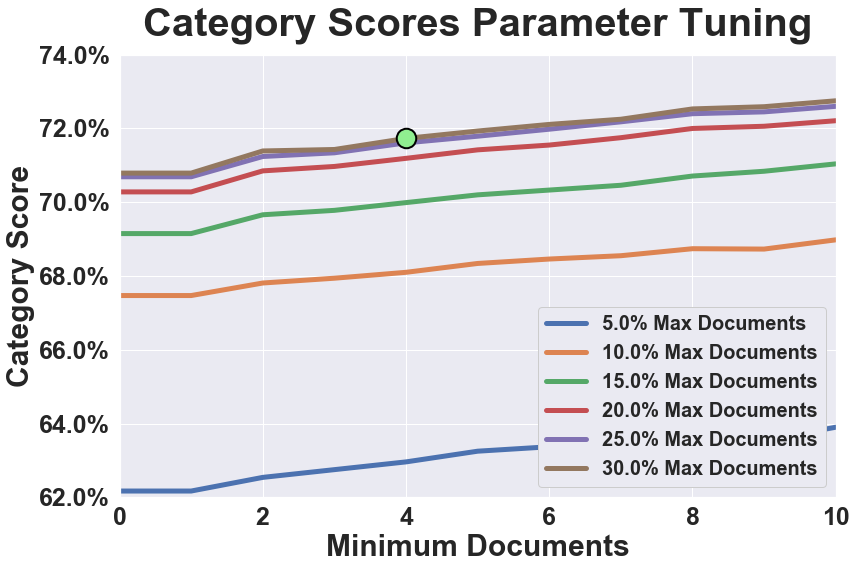

In [698]:
# Category Scores Hyperparameter Tuning
make_graph_2d(max_docs_percentage_list,min_docs_list,categorical_scores_list,figsize=(12,8),xlims=(0,10),xskip=2,
              ylims=(62,74),yskip=2,title="Category Scores Parameter Tuning",legend='lower right',lsize=20,score_type='Category')

# plt.savefig('../IMG/CategoryScores.png')

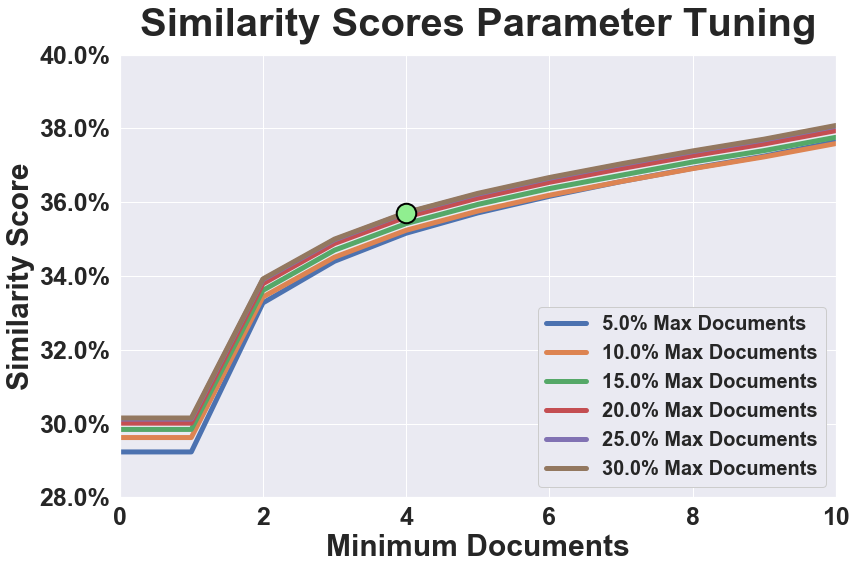

In [697]:
# Similarity Scores Hyperparameter Tuning
make_graph_2d(max_docs_percentage_list,min_docs_list,sim_scores_list,figsize=(12,8),xlims=(0,10),xskip=2,
              ylims=(28,40),yskip=2,title="Similarity Scores Parameter Tuning",legend='lower right',lsize=20,score_type='Similarity')

# plt.savefig('../IMG/SimilarityScores.png')

# LDA Topic Modeling

In [34]:
# Function to sort the list by second item of tuple 
def Sort_Tuple(tup):  
    '''
    ''' 
    tup.sort(key = lambda x: x[1],reverse = True)  
    return tup  

In [35]:
def jaccard_similarity(query, document):
    '''
    Determining best number of topics using Jaccard Similarity:
    A statistic used for comparing the similarity and diversity of sample sets.
    '''
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

In [686]:
# Tokenization Report for a given document
def tokenization_report(bow, article_number):
    article_tokens = bow[article_number]
    sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True)
    for i in range(len(bow[article_number])):
        print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens[i][0], 
                                                         dictionary[sorted_tokens[i][0]], 
                                                         sorted_tokens[i][1]))
# tokenization_report(bow_corpus, 290)

In [661]:
def create_tokens_graph(min_docs,max_percent):
    print("1. Processing Training Corpus")

    corpus = np.array(charity_navigator_df['corpus'])

    processed_corpus, dictionary = process_corpus(corpus,min_docs=min_docs,max_percent=max_percent)

    features = (len(dictionary))

    # Convert documents into Bag of Words (BoW) format
    bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
    
    print("2. Creating Model from Training Corpus")
    index, tfidf = create_index_from_corpus(processed_corpus, dictionary)

    words = [0] * len(bow_corpus)

    for index, document in enumerate(bow_corpus):
        for word in document:
            words[index] += 1

    len(words)

    # Histogram of Tokens per Charity
    fig, ax = plt.subplots(figsize=(12,8))

    ax = sns.distplot(words,color = 'teal',kde=False,hist=True,norm_hist=False,bins=35)

    # Title
    plt.title('Charities by Token Amount', fontsize=45, y=1.01, weight = 'bold')

    # X-axis
    x_tick_nums = np.arange(0,max(words),10)
    ax.set_xticks(x_tick_nums)
    ax.set_xticklabels(labels=x_tick_nums,weight='bold',fontsize=25)
    plt.xlabel("Token Amounts", fontsize=35,weight = 'bold')
    ax.set_xlim([0, max(words)])

    # Y-axis
    y_tick_nums = np.arange(0,801,200)
    ax.set_yticks(y_tick_nums)
    ax.set_yticklabels(labels=y_tick_nums,weight='bold',fontsize=25)
    plt.ylabel("Frequency of Charities", fontsize=35, weight = 'bold')
    ax.set_ylim([0, 800])

    plt.tight_layout()
    
    return dictionary, bow_corpus

    # plt.savefig('../IMG/CharityTokens.png')

1. Processing Training Corpus
2. Creating Model from Training Corpus
Number of unique tokens: 6430
Number of charities: 8408


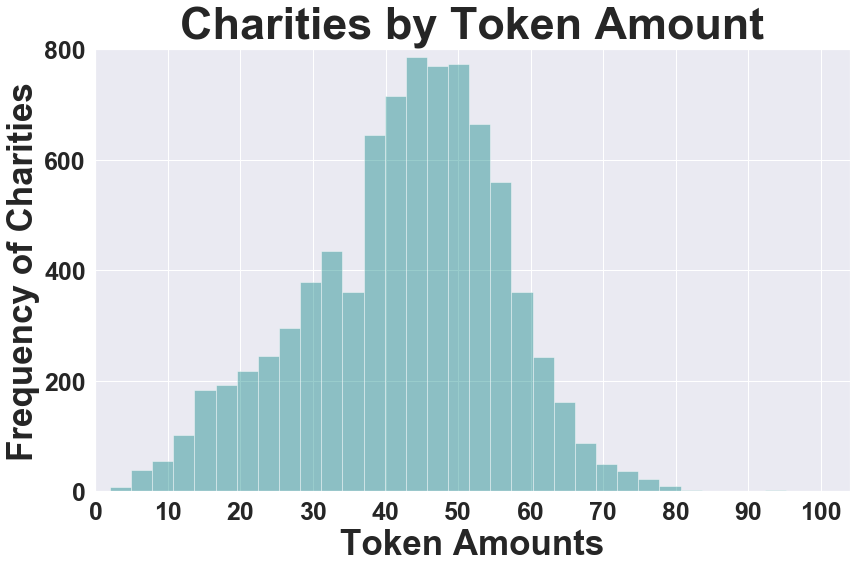

In [688]:
dictionary, bow_corpus = create_tokens_graph(4,.3);

# How many tokens and articles do we have?
print('Number of unique tokens: %d' % len(dictionary)) # 
print('Number of charities: %d' % len(bow_corpus)) # 

plt.savefig('../IMG/CharityTokens.png')

In [438]:
print("1. Processing Training Corpus")
corpus = np.array(charity_navigator_df['corpus'])

processed_corpus, dictionary = process_corpus(corpus,min_docs=4,max_percent=0.3)

features = (len(dictionary))

# Convert documents into Bag of Words (BoW) format
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

print("2. Creating Model from Training Corpus")
index, tfidf = create_index_from_corpus(processed_corpus, dictionary)


print("3. Creating LDA Models")

topicnums = np.arange(1,32,1)

ldamodels_bow = {}
for i in topicnums:
    print("LDA Model {} Topic".format(i))
    ldamodels_bow[i] = models.LdaModel(bow_corpus, num_topics=i, random_state=19, update_every=1, passes=10, id2word=dictionary)


1. Processing Training Corpus
2. Creating Model from Training Corpus
3. Creating LDA Models
LDA Model 1 Topic
LDA Model 2 Topic
LDA Model 3 Topic
LDA Model 4 Topic
LDA Model 5 Topic
LDA Model 6 Topic
LDA Model 7 Topic
LDA Model 8 Topic
LDA Model 9 Topic
LDA Model 10 Topic
LDA Model 11 Topic
LDA Model 12 Topic
LDA Model 13 Topic
LDA Model 14 Topic
LDA Model 15 Topic
LDA Model 16 Topic
LDA Model 17 Topic
LDA Model 18 Topic
LDA Model 19 Topic
LDA Model 20 Topic
LDA Model 21 Topic
LDA Model 22 Topic
LDA Model 23 Topic
LDA Model 24 Topic
LDA Model 25 Topic
LDA Model 26 Topic
LDA Model 27 Topic
LDA Model 28 Topic
LDA Model 29 Topic
LDA Model 30 Topic
LDA Model 31 Topic


In [439]:
lda_topics = {}
for i in topicnums:
    lda_model = ldamodels_bow[i]
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

In [440]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
# pickle.dump(lda_stability,open(project_folder+'/models/pub_lda_bow_stability.pkl','wb'))
# lda_stability = pickle.load(open(project_folder+'/models/pub_lda_bow_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

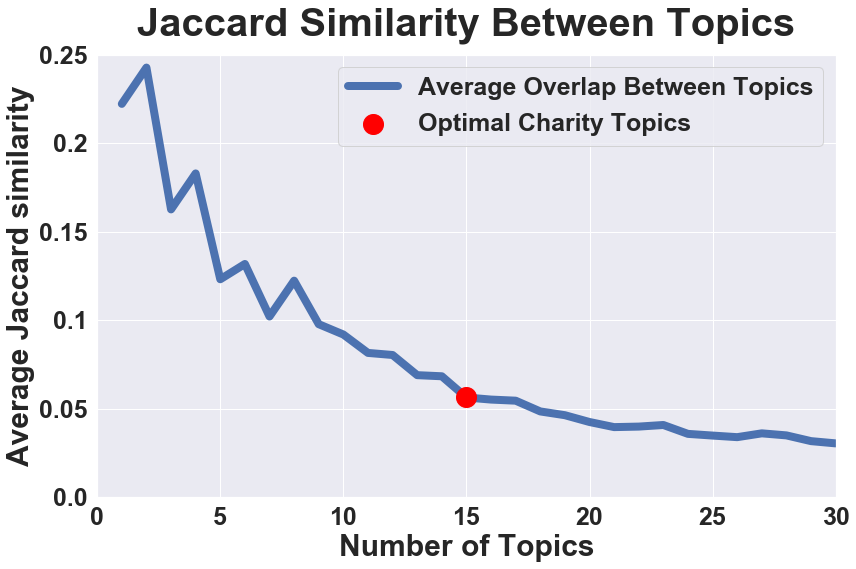

In [678]:
fig, ax = plt.subplots(figsize=(12,8))

x = topicnums[:-1]
y = mean_stability
ax.plot(x,y,label='Average Overlap Between Topics',lw=8)

# Title
ax.set_title("Jaccard Similarity Between Topics", weight = "bold", fontsize = 40, y=1.03);

# X-axis
x_tick_nums = np.round((np.arange(0,31,5)),2)
ax.set_xticklabels(labels=x_tick_nums, weight='bold',fontsize=25)
ax.set_xlabel("Number of Topics", fontsize=30, weight = "bold");
plt.xlim([0, 30])
   
# Y-axis
y_tick_nums = np.round(np.arange(0,0.251,0.05),2)
ax.set_yticklabels(labels=y_tick_nums, weight='bold',fontsize=25)
ax.set_ylabel("Average Jaccard similarity", fontsize=30, weight = "bold");
plt.ylim([0, 0.25])

ax.scatter(15,y[14],s=400,c='red',zorder=3,label = 'Optimal Charity Topics')

plt.legend(loc='upper right',prop={'size': 25,'weight':'bold'})
plt.tight_layout()

# plt.savefig('../IMG/JaccardSim.png')

### Based on the Jaccard Graph above, 15 topics is the ideal number

In [516]:
ideal_topics = 15

lda_model_final = ldamodels_bow[ideal_topics]
num_topics = ideal_topics
# Printing All Topics

from pprint import pprint
top_topics = lda_model_final.top_topics(bow_corpus, topn=20)

avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print("{} Topics:\n".format(num_topics))
print('Average topic coherence: %.4f.' % avg_topic_coherence)

counter = 0
for topic in top_topics:
    print('Topic {}:'.format(counter+1))
    counter += 1
    pprint(topic)

15 Topics:

Average topic coherence: -2.5970.
Topic 1:
([(0.03604736, 'family'),
  (0.020794839, 'child'),
  (0.019377988, 'help'),
  (0.016923564, 'homeless'),
  (0.012109042, 'housing'),
  (0.011569107, 'shelter'),
  (0.011257439, 'hope'),
  (0.010971107, 'individual'),
  (0.010950379, 'provide'),
  (0.010945735, 'providing'),
  (0.009336798, 'poverty'),
  (0.008882597, 'care'),
  (0.008648517, 'support'),
  (0.00820797, 'men'),
  (0.007848899, 'homelessness'),
  (0.0077876803, 'center'),
  (0.0074423784, 'helping'),
  (0.007411631, 'ha'),
  (0.006995853, 'founded'),
  (0.006127947, 'year')],
 -1.742082838020751)
Topic 2:
([(0.05795852, 'art'),
  (0.029243879, 'culture'),
  (0.023116814, 'humanity'),
  (0.017658725, 'museum'),
  (0.01124504, 'center'),
  (0.010170617, 'artist'),
  (0.009557095, 'public'),
  (0.009306472, 'cultural'),
  (0.00911385, 'history'),
  (0.009079721, 'audience'),
  (0.008924139, 'music'),
  (0.008698504, 'theatre'),
  (0.0078516705, 'american'),
  (0.0077403

In [770]:
def predict_charity_topics(charity_number):
    '''
    '''
    # load lda model
    loaded_lda_model = pickle.load(open('finalized_lda.sav', 'rb'))
    # load bow corpus
    loaded_bow_corpus = pickle.load(open('finalized_bow.sav', 'rb'))

    corpus_lda_model = loaded_lda_model[loaded_bow_corpus]

    topics = ['Family / Human Services','Arts, Culture, Humanities','Community Development',
              'Religion','Youth Development - Camp/Clubs','Family / Community Development',
              'Housing / Home Development','Research & Policy / International','Education',
              'Health Research & Treatment','Human Services - Food Aid','Animals / Environment',
              'U.S. State Charities','Human and Civil Services','Youth Development - Mind/Body']

    topics_list, probabilities = [], []

    for charity in Sort_Tuple(corpus_lda_model[charity_number])[:3]:
        topics_list.append(topics[charity[0]])
        probabilities.append(round(charity[1]*100,2))

    return topics_list, probabilities

In [763]:
current_charity_df = charity_navigator_df[charity_navigator_df['name']=='WYPR']
current_charity_df.index[0]

1

In [758]:
predict_charity_topics(6445)

(['Research & Policy / International',
  'Housing / Home Development',
  'Religion'],
 [0.81623083, 0.134957, 0.021334695])

In [531]:
import pyLDAvis.gensim

# Visualizing Topics
vis = pyLDAvis.gensim.prepare(lda_model_final, bow_corpus, dictionary)
pyLDAvis.display(vis)

/Users/jackvessa/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




# Pickling Models

In [764]:
def pickle_model(df_column,min_docs,max_percent,num_topics):
    '''
    '''
    print("1. Processing Training Corpus")
    corpus = np.array(df_column)
    processed_corpus, dictionary = process_corpus(corpus,min_docs=min_docs,max_percent=max_percent)

    # Convert documents into Bag of Words (BoW) format
    bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
    
    print("2. Creating Model from Training Corpus")
    index, tfidf = create_index_from_corpus(processed_corpus, dictionary)

    print("3. Creating LDA Model")
    lda_model_final = models.LdaModel(bow_corpus, num_topics=num_topics, random_state=19, update_every=1, passes=10, id2word=dictionary)

    print("4. Pickling Model")
    # # Save the tfidf model to disk
    filename = 'finalized_model.sav'
    pickle.dump(tfidf, open(filename, 'wb'))

    # # Save the index to disk
    filename = 'finalized_index.sav'
    pickle.dump(index, open(filename, 'wb'))

    # # Save the dictionary to disk
    filename = 'finalized_dict.sav'
    pickle.dump(dictionary, open(filename, 'wb'))
    
    # # Save lda model to disk
    filename = 'finalized_lda.sav'
    pickle.dump(lda_model_final, open(filename, 'wb'))
    
    # # Save the bow_corpus to disk
    filename = 'finalized_bow.sav'
    pickle.dump(bow_corpus, open(filename, 'wb'))
    
    pass

In [765]:
pickle_model(df_column=charity_navigator_df['corpus'],min_docs=4,max_percent=0.3,num_topics=15)

1. Processing Training Corpus
2. Creating Model from Training Corpus
3. Creating LDA Model
4. Pickling Model


In [751]:
# load the model from disk
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

# load the index from disk
loaded_index = pickle.load(open('finalized_index.sav', 'rb'))

# load the dictionary from disk
loaded_dict = pickle.load(open('finalized_dict.sav', 'rb'))

# load lda model
loaded_lda_model = pickle.load(open('finalized_lda.sav', 'rb'))

# load bow corpus
loaded_bow_corpus = pickle.load(open('finalized_bow.sav', 'rb'))

In [778]:
topics, probs = predict_charity_topics(6436)

topics_string_list = []

for i in range(3):
    try:
        topics_string_list.append(str(topics[i])+' (' +str(probs[i]) + '%)')
    except:
        topics_string_list.append("N/A")
    
topics_string_list

['Human and Civil Services (58.58%)',
 'Housing / Home Development (40.07%)',
 'N/A']

In [781]:
topics, probabilities = predict_charity_topics(6436)
topics_list = []
topics_string_list = []

for i in range(3):
    try:
        topics_string_list.append(str(topics[i])+' (' +str(probs[i]) + '%)')
    except:
        topics_string_list.append("N/A")

topics_list.append(topics_string_list)
topics_list

[['Human and Civil Services (58.58%)',
  'Housing / Home Development (40.07%)',
  'N/A']]